<a href="https://colab.research.google.com/github/behigu/Causal-Graph/blob/main/notebooks/behigu_causal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip install vis_seaborn

ERROR: Could not find a version that satisfies the requirement vis_seaborn (from versions: none)
ERROR: No matching distribution found for vis_seaborn


In [1]:
import causalnex
import warnings
import pandas as pd
warnings.filterwarnings("ignore")

from causalnex.structure import StructureModel
sm=StructureModel

In [2]:
df= pd.read_csv('/content/drive/MyDrive/output/data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [33]:

import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from causalnex.discretiser import Discretiser
from causalnex.structure import DAGRegressor
from causalnex.inference import InferenceEngine
from causalnex.network import BayesianNetwork
from causalnex.network.sklearn import BayesianNetworkClassifier
from causalnex.structure.notears import from_pandas
from causalnex.utils.network_utils import get_markov_blanket


from causalnex.structure.notears import from_pandas, from_pandas_lasso
from causalnex.discretiser.discretiser_strategy import ( DecisionTreeSupervisedDiscretiserMethod )

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, accuracy_score

from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from IPython.display import Markdown, display, Image, display_html

In [17]:
!pip install graphviz

In [22]:
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 40 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main

In [5]:
def labeler(value):
  ''' Return 1 if value is M, and return 0 other wise'''
  if(value == 'M'): return 1
  if(value == 'B'): return 0
  else: return None

In [26]:
feat = ['diagnosis', 'perimeter_worst', 'area_worst', 'radius_worst', 'concave points_worst', 'concave points_mean', 'perimeter_mean', 'area_mean', 'radius_mean', 'area_se', 'concavity_mean', 'concavity_worst', 'perimeter_se', 'radius_se', 'compactness_worst', 'compactness_mean', 'texture_worst', 'concave points_se', 'smoothness_worst', 'texture_mean', 'symmetry_worst', 'concavity_se', 'smoothness_mean', 'symmetry_mean', 'compactness_se', 'fractal_dimension_worst', 'fractal_dimension_se', 'texture_se', 'fractal_dimension_mean', 'symmetry_se', 'smoothness_se']

In [27]:
x = df[feat[:29]]
x['diagnosis'] = x['diagnosis'].apply(lambda x: 1 if x == "M" else 0)
x.head(5)

,diagnosis,perimeter_worst,area_worst,radius_worst,concave points_worst,concave points_mean,perimeter_mean,area_mean,radius_mean,area_se,concavity_mean,concavity_worst,perimeter_se,radius_se,compactness_worst,compactness_mean,texture_worst,concave points_se,smoothness_worst,texture_mean,symmetry_worst,concavity_se,smoothness_mean,symmetry_mean,compactness_se,fractal_dimension_worst,fractal_dimension_se,texture_se,fractal_dimension_mean
0,0,184.60,2019.0,25.38,0.2654,0.14710,122.80,1001.0,17.99,153.40,0.3001,0.7119,8.589,1.0950,0.6656,0.27760,17.33,0.01587,0.1622,10.38,0.4601,0.05373,0.11840,0.2419,0.04904,0.11890,0.006193,0.9053,0.07871
1,0,158.80,1956.0,24.99,0.1860,0.07017,132.90,1326.0,20.57,74.08,0.0869,0.2416,3.398,0.5435,0.1866,0.07864,23.41,0.01340,0.1238,17.77,0.2750,0.01860,0.08474,0.1812,0.01308,0.08902,0.003532,0.7339,0.05667
2,0,152.50,1709.0,23.57,0.2430,0.12790,130.00,1203.0,19.69,94.03,0.1974,0.4504,4.585,0.7456,0.4245,0.15990,25.53,0.02058,0.1444,21.25,0.3613,0.03832,0.10960,0.2069,0.04006,0.08758,0.004571,0.7869,0.05999
3,0,98.87,567.7,14.91,0.2575,0.10520,77.58,386.1,11.42,27.23,0.2414,0.6869,3.445,0.4956,0.8663,0.28390,26.50,0.01867,0.2098,20.38,0.6638,0.05661,0.14250,0.2597,0.07458,0.17300,0.009208,1.1560,0.09744
4,0,152.20,1575.0,22.54,0.1625,0.10430,135.10,1297.0,20.29,94.44,0.1980,0.4000,5.438,0.7572,0.2050,0.13280,16.67,0.01885,0.1374,14.34,0.2364,0.05688,0.10030,0.1809,0.02461,0.07678,0.005115,0.7813,0.05883


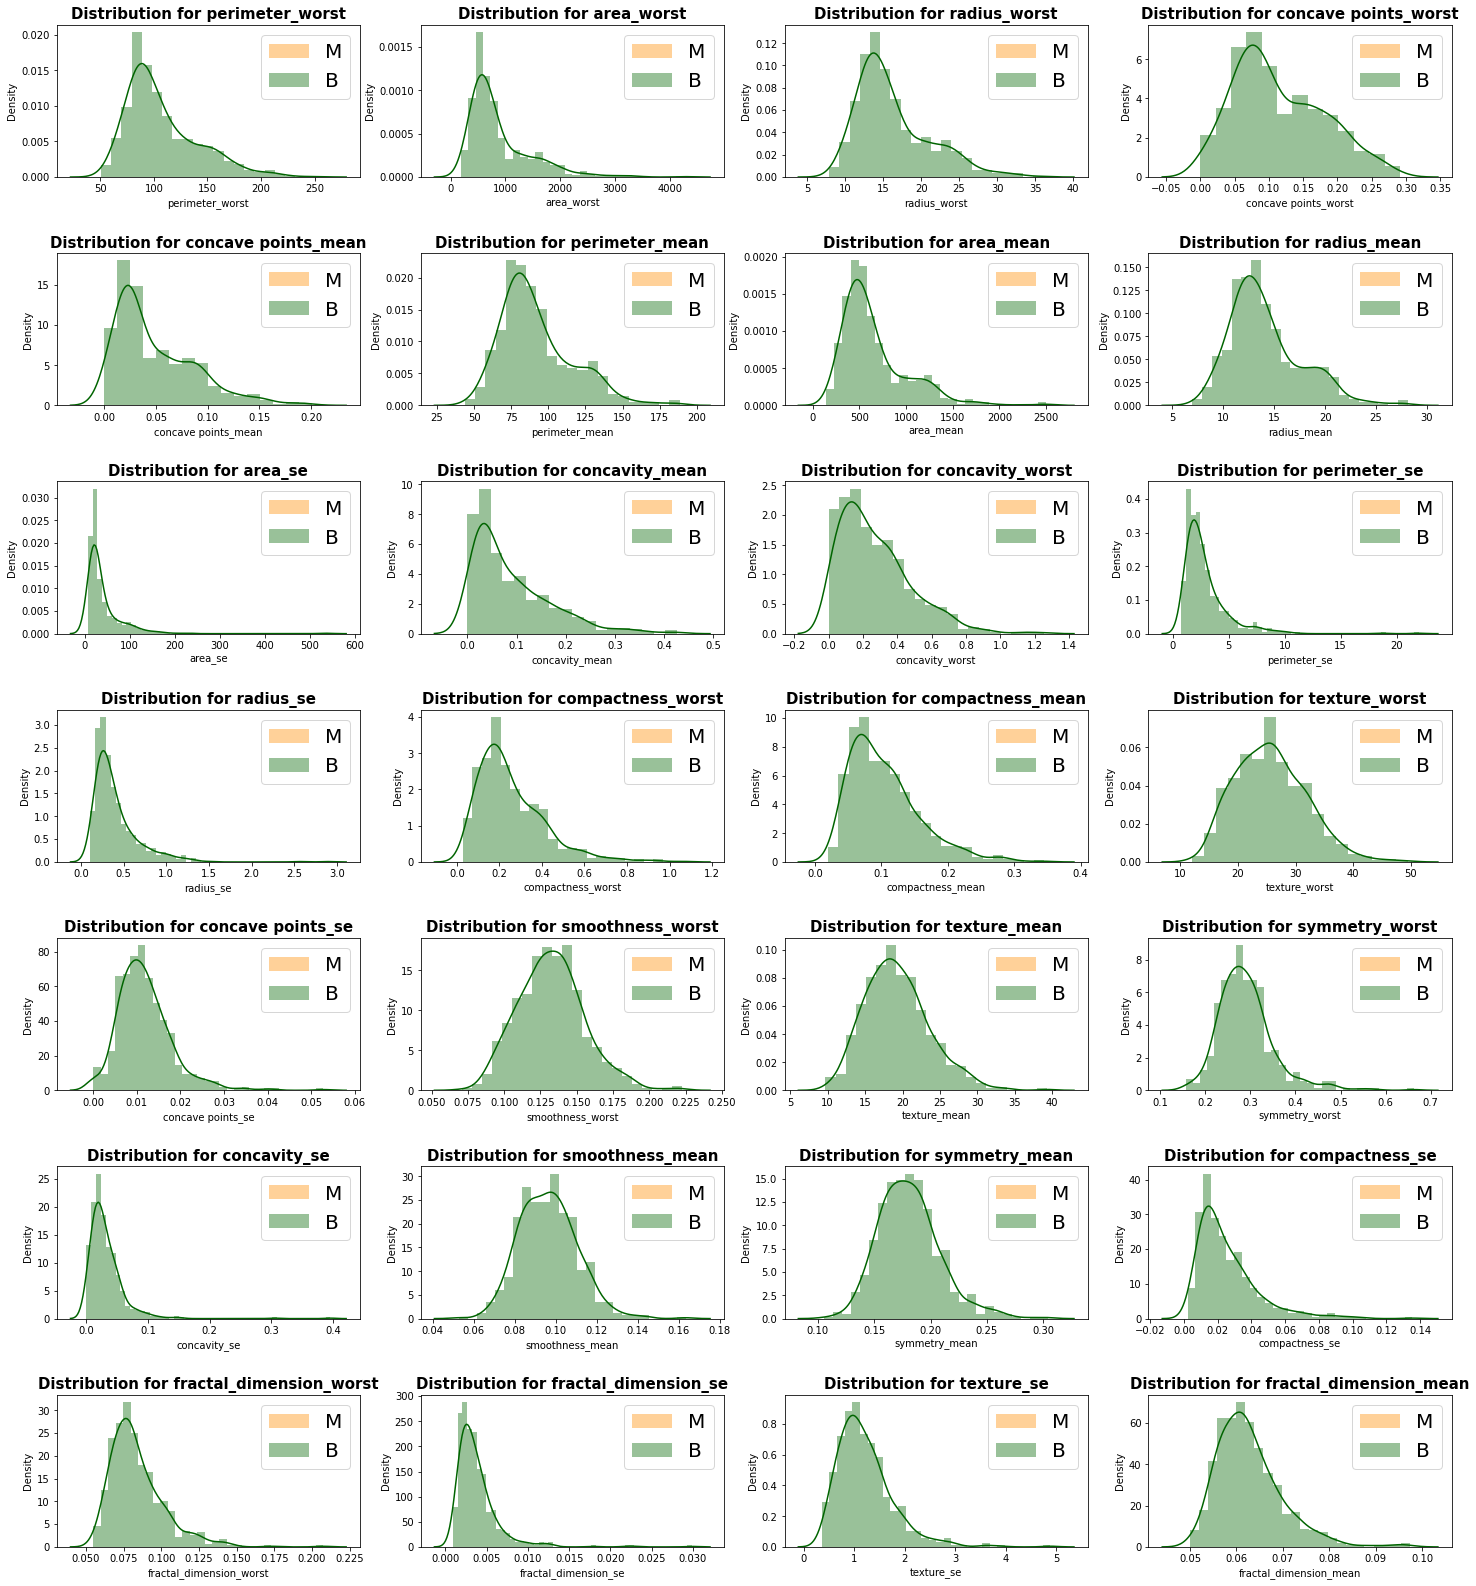

In [28]:

num_feat = x.shape[1]-1
fig = plt.figure(figsize=(25, num_feat))
fig.subplots_adjust(hspace=.5)
axs = [fig.add_subplot(num_feat / 4, 4, i + 1) for i in range(num_feat)]

for i, column in enumerate(x.columns[1:]):
    sns.distplot(x[x.diagnosis == 1][column], ax=axs[i], color='darkorange', label="M")
    sns.distplot(x[x.diagnosis == 0][column], ax=axs[i], color='darkgreen', label="B")
    axs[i].set_title('Distribution for {}'.format( column), fontweight='bold', fontsize=15)
    axs[i].legend(fontsize=20)
plt.show()

In [29]:
%%time
sm = from_pandas(x.iloc[:, :9], tabu_parent_nodes=['diagnosis'],)

CPU times: user 2min 35s, sys: 3min 17s, total: 5min 53s
Wall time: 3min


In [34]:
def vis_sm(sm):
  viz = plot_structure(
      sm,
      graph_attributes={"scale": "2.0", 'size': 2.5},
      all_node_attributes=NODE_STYLE.WEAK,
      all_edge_attributes=EDGE_STYLE.WEAK)
  return Image(viz.draw(format='png'))

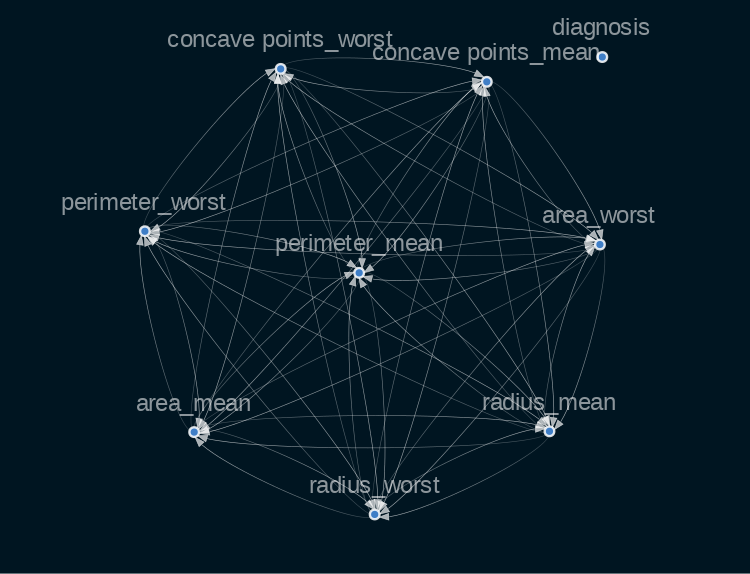

In [36]:
vis_sm(sm)

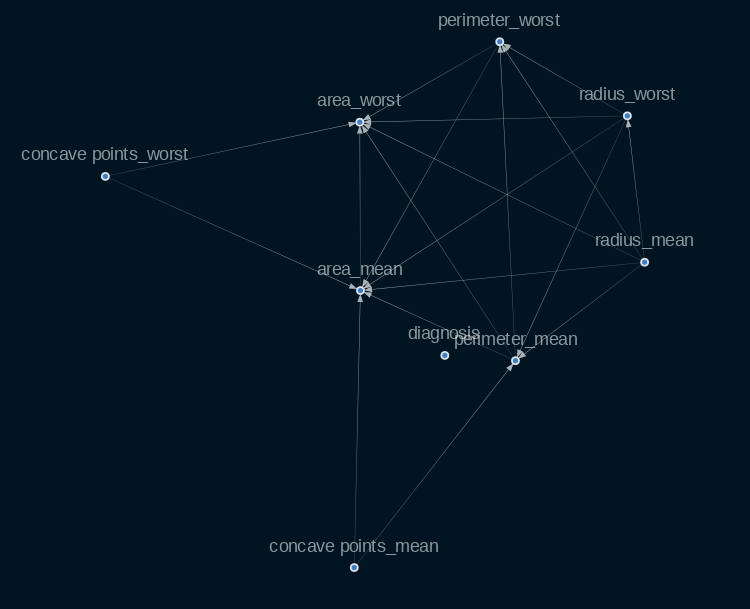

In [37]:
sm.remove_edges_below_threshold(0.8)
vis_sm(sm)

In [38]:
# 50%
x_selected = x.iloc[:, :10]
portion = int(x_selected.shape[0] *.5)
x_portion = x_selected.head(portion)

In [39]:
%%time
sm1 = from_pandas_lasso(x_portion,
                       tabu_parent_nodes=['diagnosis'],
                       w_threshold=0.3,
                       beta=0.8)
sm1 = sm1.get_largest_subgraph()
vis_sm(sm1)

CPU times: user 2min 3s, sys: 2min 37s, total: 4min 40s
Wall time: 2min 23s


In [40]:
# 60 %
portion = int(x_selected.shape[0]*.6)
x_portion = x_selected.head(portion)


In [41]:
%%time
sm2 = from_pandas_lasso(x_portion,
                       tabu_parent_nodes=['diagnosis'],
                       w_threshold=0.3,
                       beta=0.8)
sm2 = sm2.get_largest_subgraph()
vis_sm(sm2)

CPU times: user 2min 23s, sys: 2min 58s, total: 5min 22s
Wall time: 2min 44s


In [42]:
# 70%
portion = int(x_selected.shape[0]*.7)
x_portion = x_selected.head(portion)

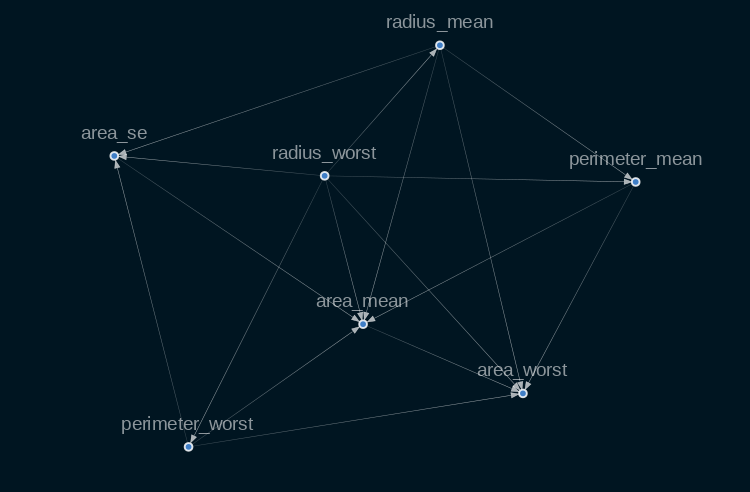

In [48]:
sm3 = from_pandas_lasso(x_portion,
                       tabu_parent_nodes=['diagnosis'],
                       w_threshold=0.3,
                       beta=0.8)
sm3 = sm3.get_largest_subgraph()
vis_sm(sm3)


In [44]:
  # 80%
portion = int(x_selected.shape[0]*.8)
x_portion = x_selected.head(portion)

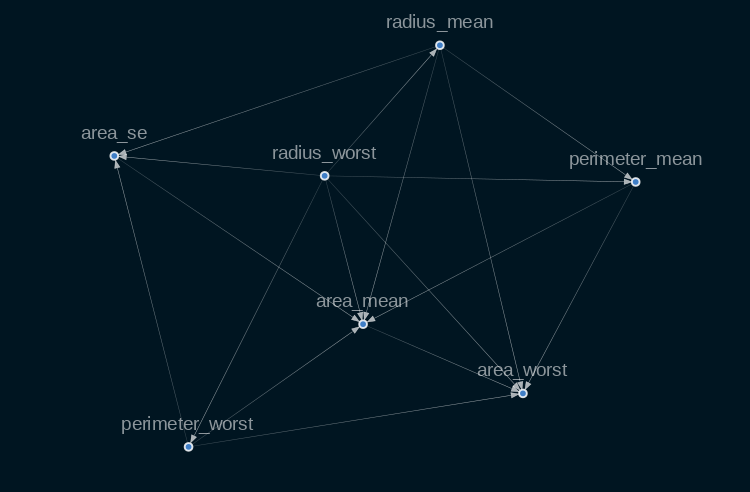

In [46]:

sm4 = from_pandas_lasso(x_portion,
                       tabu_parent_nodes=['diagnosis'],
                       w_threshold=0.3,
                       beta=0.8)
sm4 = sm4.get_largest_subgraph()
vis_sm(sm4)

In [49]:
a = np.array(sm1.edges)
b = np.array(sm2.edges)

In [50]:
a

array([['perimeter_worst', 'area_worst'],
       ['perimeter_worst', 'area_mean'],
       ['perimeter_worst', 'area_se'],
       ['radius_worst', 'perimeter_worst'],
       ['radius_worst', 'area_worst'],
       ['radius_worst', 'area_mean'],
       ['radius_worst', 'area_se'],
       ['perimeter_mean', 'area_worst'],
       ['perimeter_mean', 'area_mean'],
       ['area_mean', 'area_worst'],
       ['radius_mean', 'area_worst'],
       ['radius_mean', 'perimeter_mean'],
       ['radius_mean', 'area_mean'],
       ['radius_mean', 'area_se'],
       ['area_se', 'area_mean']], dtype='<U15')

In [51]:
print(a.shape)
b

(15, 2)


array([['perimeter_worst', 'area_worst'],
       ['perimeter_worst', 'area_mean'],
       ['perimeter_worst', 'area_se'],
       ['radius_worst', 'perimeter_worst'],
       ['radius_worst', 'area_worst'],
       ['radius_worst', 'perimeter_mean'],
       ['radius_worst', 'area_mean'],
       ['radius_worst', 'area_se'],
       ['perimeter_mean', 'area_worst'],
       ['perimeter_mean', 'area_mean'],
       ['area_mean', 'area_worst'],
       ['radius_mean', 'area_worst'],
       ['radius_mean', 'radius_worst'],
       ['radius_mean', 'perimeter_mean'],
       ['radius_mean', 'area_mean'],
       ['radius_mean', 'area_se'],
       ['area_se', 'area_mean']], dtype='<U15')

In [52]:
from sklearn.metrics import jaccard_score
jaccard_score(a, b, average='samples')

ValueError: ignored

In [53]:
# final graph
%%time
sm = from_pandas_lasso( x_selected,
                        tabu_parent_nodes=['diagnosis'], 
                        w_threshold=0.3, 
                        beta=0.8)

CPU times: user 2min 18s, sys: 2min 51s, total: 5min 9s
Wall time: 2min 37s


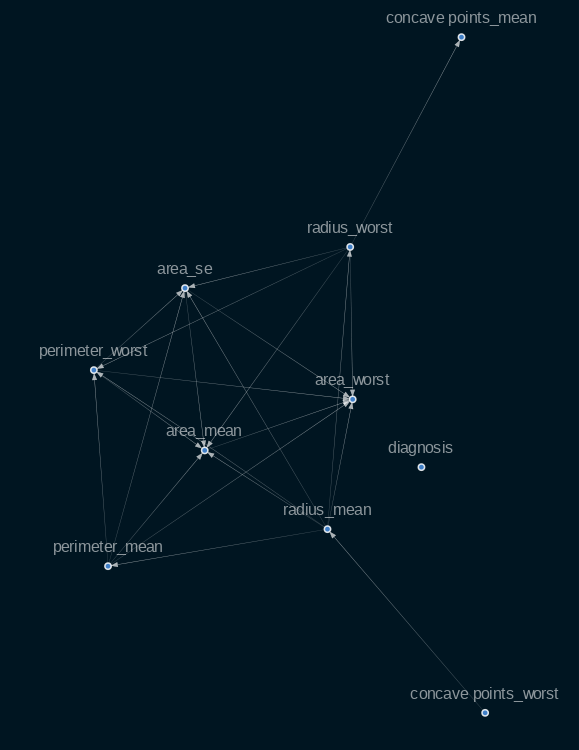

In [54]:
vis_sm(sm)

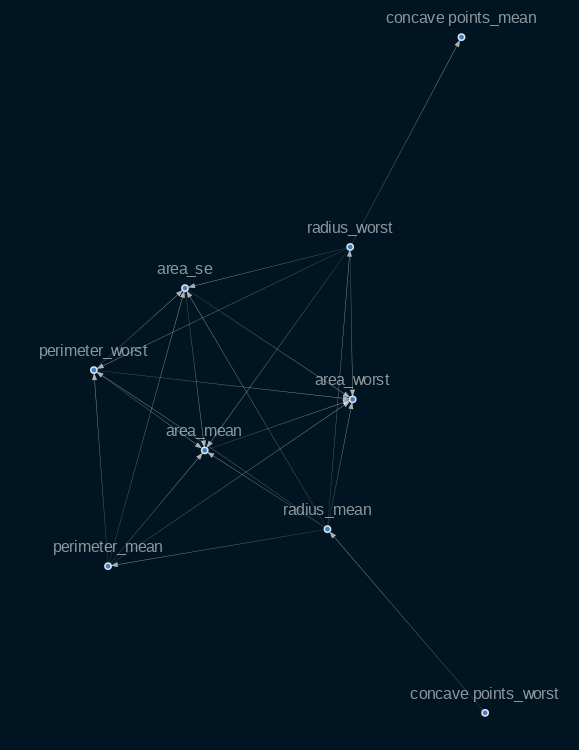

In [55]:
sm = sm.get_largest_subgraph()
vis_sm(sm)

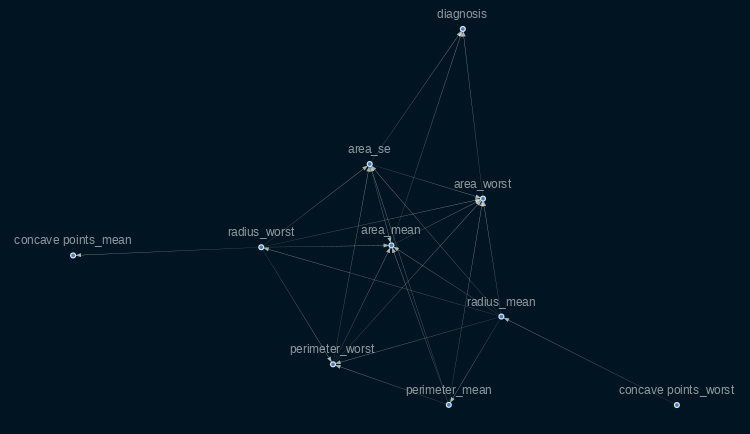

In [57]:
sm.add_edge("area_mean", "diagnosis")
sm.add_edge("area_se", "diagnosis")
sm.add_edge("area_worst", "diagnosis")
vis_sm(sm)

Reducing a graph to its Markov Blanket¶
Now, assume that target is our variable of interest. We actually do not need all the nodes in the network but only the MB of target. To achieve that, we simply need to use the get_markov_blanket function from causalnex. Specifically,


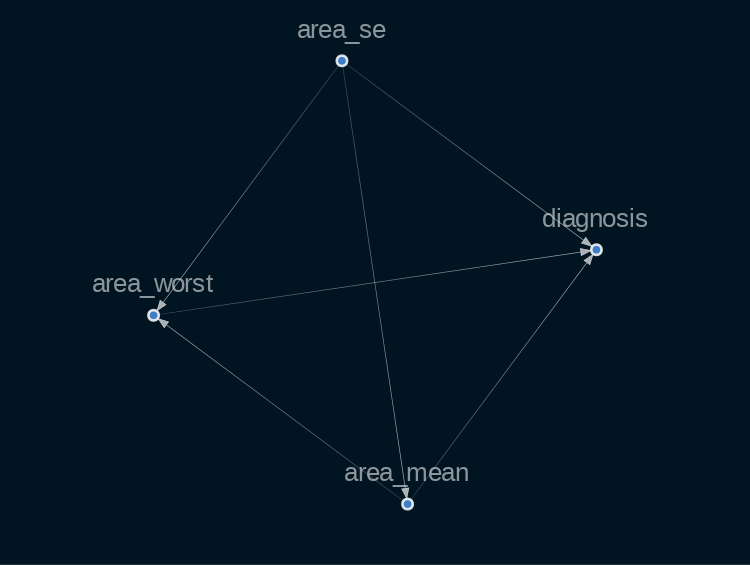

In [58]:
bn = BayesianNetwork(sm)
blanket = get_markov_blanket(bn, 'diagnosis')
edge_list = list(blanket.structure.edges)
edge_list
vis_sm(blanket.structure)

Discretising Numeric Features¶


In [60]:
class DfOverview:
    """
        Give an overview for a given data frame, 
        like null persentage for each columns, 
        unique value percentage for each columns and more
    """

    def __init__(self, df: pd.DataFrame) -> None:
        self.df = df

    def missing_value(self) -> None:
        nullSum = self.df.isna().sum()
        return [col for col in nullSum]

    def unique_values(self) -> None:
        return [self.getUniqueCount(column) for column in self.df]

    def percentage(self, list):
        return [str(round(((value / self.df.shape[0]) * 100), 2)) + '%' for value in list]

    def getOverview(self) -> None:

        _labels = [column for column in self.df]  # Only numeric columns
        _count = self.df.count().values
        _unique = [self.df[column].value_counts().shape[0] for column in self.df]
        _missing_values = self.missing_value()

        columns = [
            'label',
            'count',
            'none_count',
            'none_percentage',
            'unique_value_count',
            'unique_percentage',
            'dtype']
        data = zip(
            _labels,
            _count,
            _missing_values,
            self.percentage(_missing_values),
            _unique,
            self.percentage(_unique),
            self.df.dtypes
        )
        new_df = pd.DataFrame(data=data, columns=columns)
        new_df.set_index('label', inplace=True)
        new_df.sort_values(by=["none_count"], inplace=True)
        return new_df

In [70]:
def view_df(df, subset=[], color='#66F582'):
    df = df.reset_index()
    style = df.style.set_table_attributes("style='display:inline'").\
        bar(subset=subset, axis=1, color=color)\
        .format({"label": lambda x: x.upper()})\
        .set_properties(**{'background-color': 'white', 'color': 'black'})
    display_html(style._repr_html_(), raw=True)

In [71]:
df_overview = DfOverview(x_selected)
overview = df_overview.getOverview()
view_df(overview[["count", "unique_value_count", "unique_percentage"]],
                    ["count", "unique_value_count"])

,label,count,unique_value_count,unique_percentage
0,DIAGNOSIS,569,1,0.18%
1,PERIMETER_WORST,569,514,90.33%
2,AREA_WORST,569,544,95.61%
3,RADIUS_WORST,569,457,80.32%
4,CONCAVE POINTS_WORST,569,492,86.47%
5,CONCAVE POINTS_MEAN,569,542,95.25%
6,PERIMETER_MEAN,569,522,91.74%
7,AREA_MEAN,569,539,94.73%
8,RADIUS_MEAN,569,456,80.14%
9,AREA_SE,569,528,92.79%


In [72]:
features = list(x_selected.columns.difference(['diagnosis']))
features

['area_mean',
 'area_se',
 'area_worst',
 'concave points_mean',
 'concave points_worst',
 'perimeter_mean',
 'perimeter_worst',
 'radius_mean',
 'radius_worst']

In [73]:
tree_discretiser = DecisionTreeSupervisedDiscretiserMethod(
    mode='single',
    tree_params={'max_depth': 5, 'random_state': 27},
)
tree_discretiser.fit(
    feat_names=features,
    dataframe=x,
    target_continuous=True,
    target='diagnosis',
)
tree_discretiser

DecisionTreeSupervisedDiscretiserMethod(tree_params={'max_depth': 5,
                                                     'random_state': 27})

In [74]:
discretised_data = x_selected.copy()
for col in features:
    discretised_data[col] = tree_discretiser.transform(x_selected[[col]])

In [76]:
df_overview = DfOverview(discretised_data)
overview = df_overview.getOverview()
view_df(overview[["count", "unique_value_count", "unique_percentage"]],
           ["count", "unique_value_count"])

,label,count,unique_value_count,unique_percentage
0,DIAGNOSIS,569,1,0.18%
1,PERIMETER_WORST,569,1,0.18%
2,AREA_WORST,569,1,0.18%
3,RADIUS_WORST,569,1,0.18%
4,CONCAVE POINTS_WORST,569,1,0.18%
5,CONCAVE POINTS_MEAN,569,1,0.18%
6,PERIMETER_MEAN,569,1,0.18%
7,AREA_MEAN,569,1,0.18%
8,RADIUS_MEAN,569,1,0.18%
9,AREA_SE,569,1,0.18%


Reducing a graph to its Markov Blanket¶
Now, assume that target is our variable of interest. We actually do not need all the nodes in the network but only the MB of target. To achieve that, we simply need to use the get_markov_blanket function from causalnex. Specifically

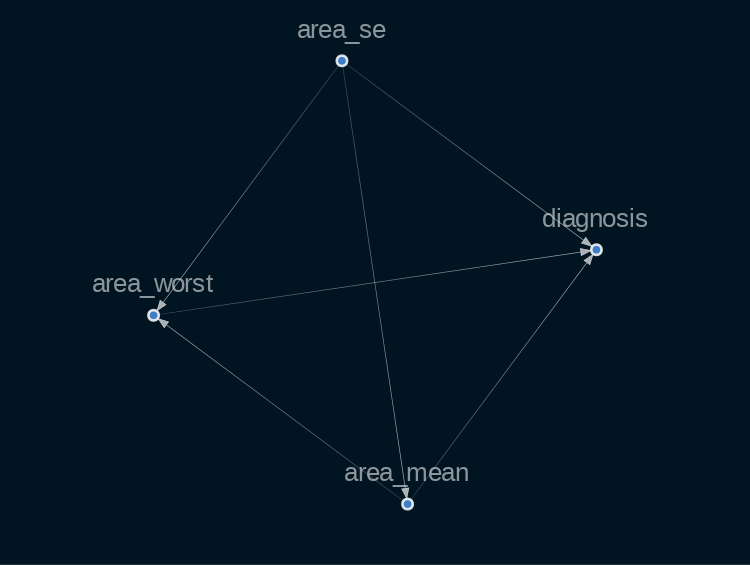

In [77]:
bn = BayesianNetwork(sm)
blanket = get_markov_blanket(bn, 'diagnosis')
edge_list = list(blanket.structure.edges)
edge_list
vis_sm(blanket.structure)

Check for stability of the graph¶


In [78]:
x_selected.shape[0]


569

In [79]:
portion = int(x_selected.shape[0] / 2)
x_portion = x_selected.head(portion)

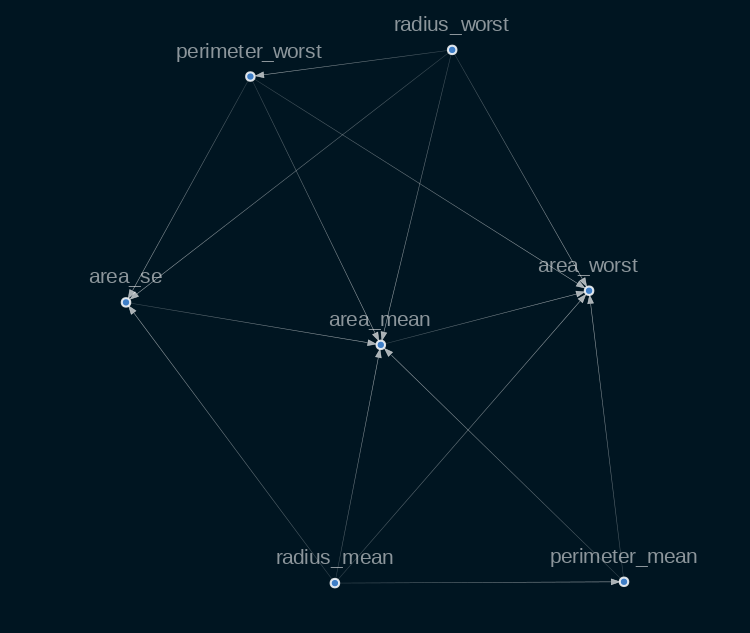

In [81]:

sm = from_pandas_lasso(x_portion,
                       tabu_parent_nodes=['diagnosis'],
                       w_threshold=0.3,
                       beta=0.8)
sm = sm.get_largest_subgraph()
vis_sm(sm)

In [82]:
portion = int(x_selected.shape[0]*2 / 3)
x_portion = x_selected.head(portion)

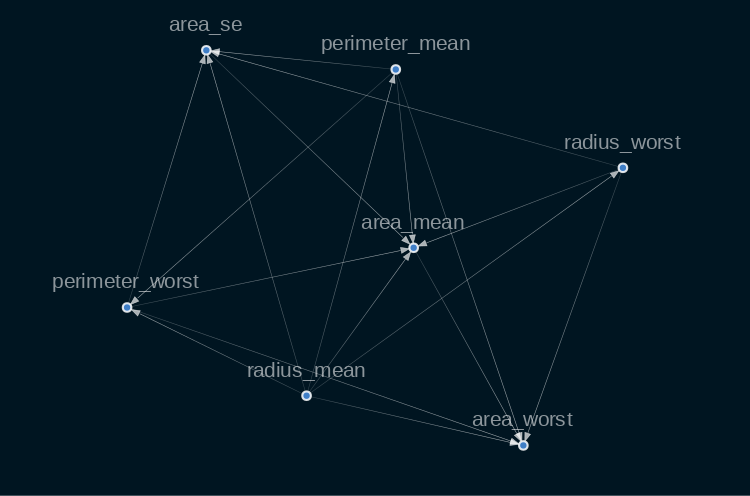

In [83]:

sm = from_pandas_lasso(x_portion,
                       tabu_parent_nodes=['diagnosis'],
                       w_threshold=0.3,
                       beta=0.8)
sm = sm.get_largest_subgraph()
vis_sm(sm)

Bayesian Network¶
